## Скачаем необходимые данные и пакеты

In [ ]:
# better to run in colab, sktime may not work on your computer
!pip install -q sktime[all_extras]

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sktime

Path_to_imgs = 'imgs'
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('clean_data_MSK.csv', sep=':')
data.iloc[:, :13].head()

,lighting,lat,long,region,category,date,severity,dead,injured,n_participants,dr_exp,w_percent,Пасмурно
0,Светлое время суток,55.616777,37.706516,Орехово-Борисово Северное,Наезд на пешехода,2020-03-24 13:06:00,Легкий,0,1,2,[28],0.0,0
1,Светлое время суток,55.841157,37.489332,Головинский,Столкновение,2018-09-15 11:00:00,Легкий,0,1,2,"[20, 6]",0.5,1
2,"В темное время суток, освещение включено",55.713332,37.658944,Даниловский,Наезд на пешехода,2016-04-14 21:25:00,Легкий,0,1,2,[],NaN,1
3,Светлое время суток,55.655243,37.414176,Солнцево,Столкновение,2019-06-20 18:15:00,Легкий,0,1,2,"[12, 1]",0.5,0
4,Светлое время суток,55.756493,37.789315,Перово,Наезд на пешехода,2016-04-04 11:50:00,Легкий,0,1,2,[15],0.0,0


## I. Визуализируем важные временные ряды

### 1) Количество погибших в автокатастрофах с 2015 по 2020 по месяца

In [5]:
df1 = data[['dead']].copy()
df1['dates_monthly'] = pd.PeriodIndex(data['date'], freq='M')
df1 = df1.sort_values(['dates_monthly'])
gb = df1.groupby('dates_monthly').sum()

months = set([*map(lambda x: x.split()[0][:7], data['date'])])
labels_m = [dt if i % 4 == 0 else '' for i, dt in enumerate(sorted(list(months)))]

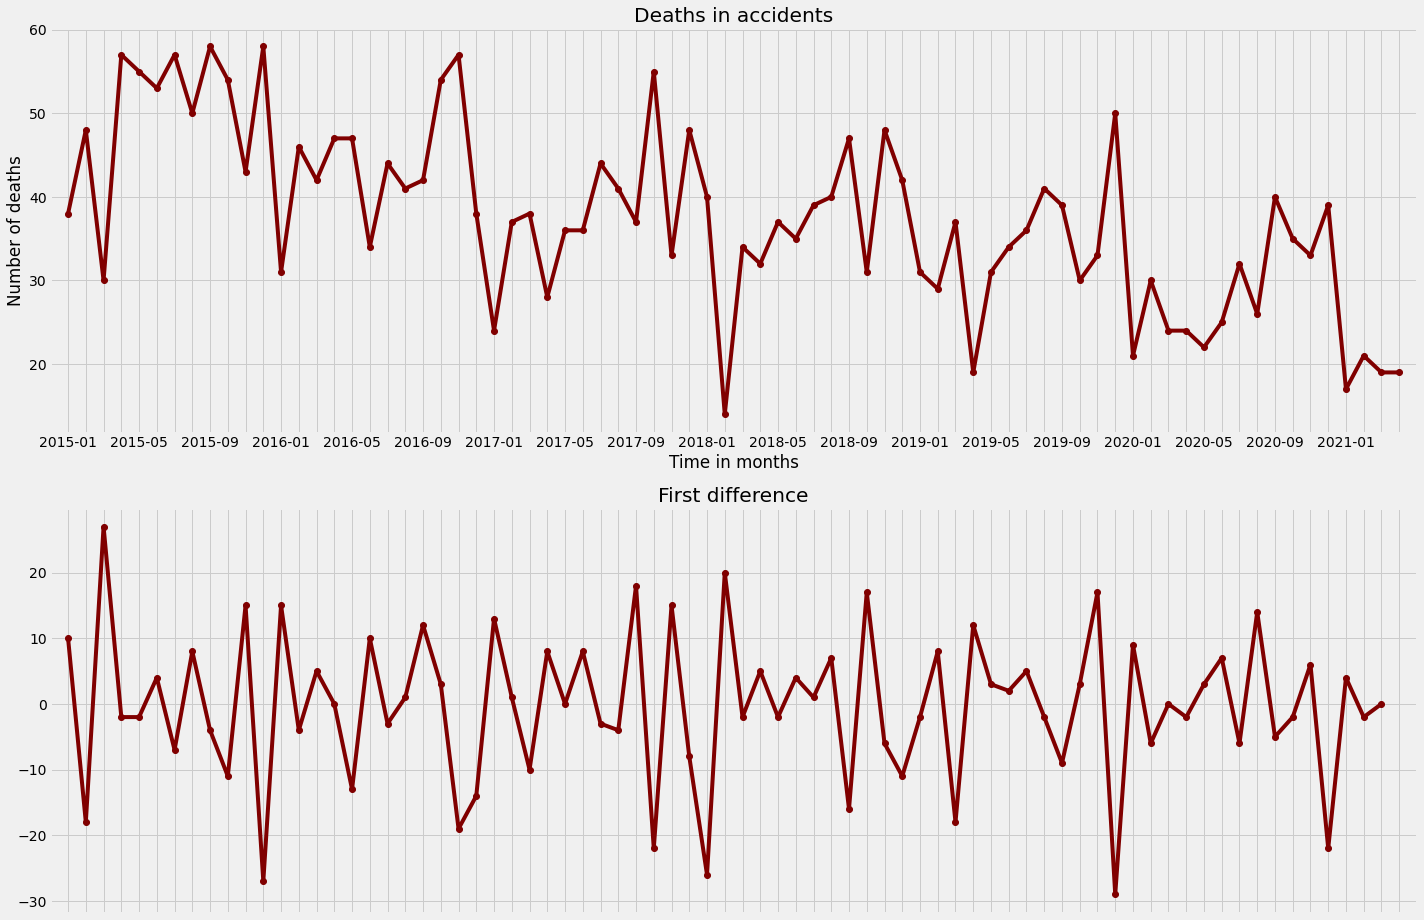

In [16]:
plt.style.use('fivethirtyeight')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 13))

ax1.plot(gb.dead.values, marker='o', c='maroon')
ax1.set_xticks(ticks = np.arange(76))
ax1.set_xticklabels(labels_m)
ax1.set_xlabel('Time in months')
ax1.set_ylabel('Number of deaths')
ax1.set_title('Deaths in accidents')
ax1.set_xlim(-1, 76)

ax2.plot(gb.dead.values[1:] - gb.dead.values[:-1], marker='o', c='maroon')
ax2.set_xticks(ticks = np.arange(76))
ax2.set_xticklabels(['']*76)
ax2.set_title('First difference')
ax2.set_xlim(-1, 76)
plt.tight_layout()
plt.savefig('{imgs}/ts_death_first_diff.svg'.format(imgs=Path_to_imgs))
plt.show()

The original series is nonstationry: it has seasonality and a trend, however the first difference seems to be stationary

### 2) Количество погибших в автокатастрофах в течение дня и количество автокатастров в течение дня

In [10]:
# making labels for every hour
hours = data['date'].apply(lambda x: x.split()[1][:2]+':00').values
labels_h = sorted(list(np.unique(hours)))

# making a slicec of a dataset 
slice2 = data[['dead']].copy()
slice2['Num_accidents'] = 1
slice2['hours'] = hours
slice2 = slice2.sort_values(['hours'])

# grouping by mean and sum
gb_mean = slice2.groupby('hours').mean()
gb_sum = slice2.groupby('hours').sum()

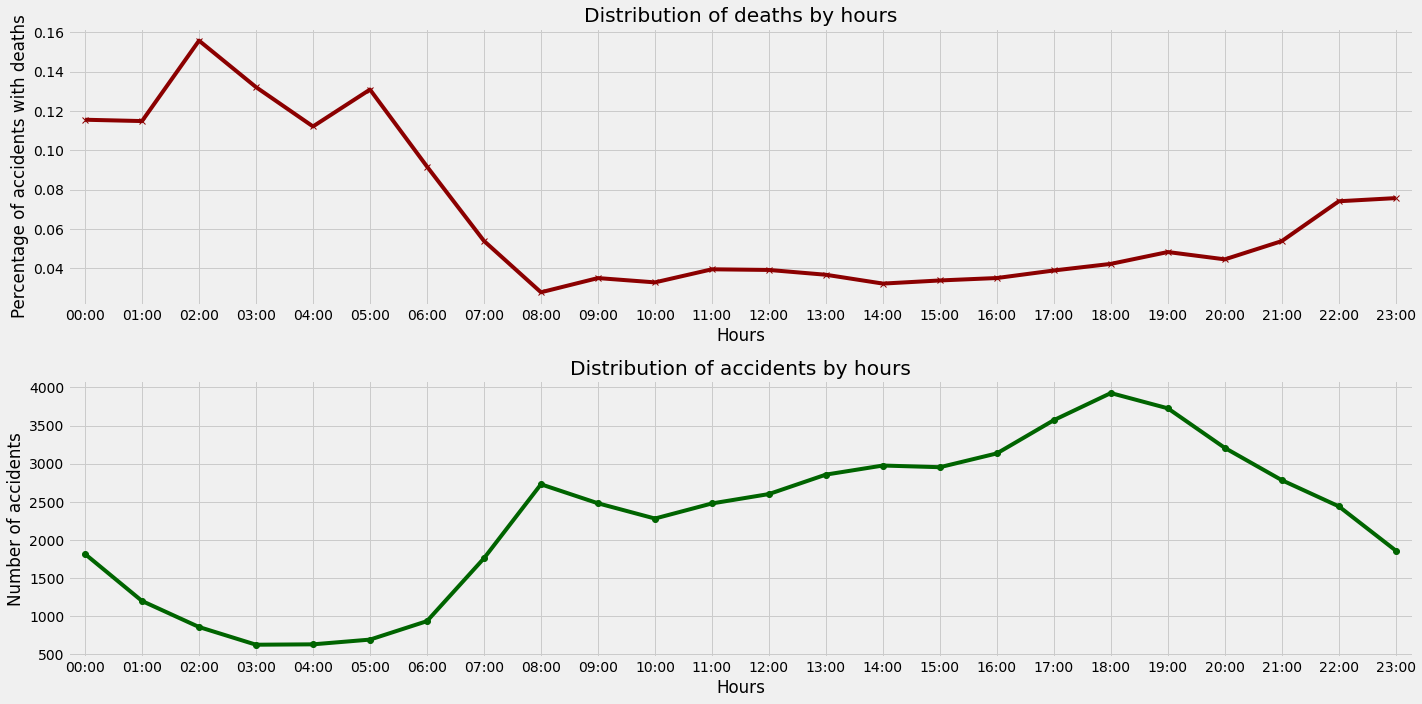

In [17]:
plt.style.use('fivethirtyeight')
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(gb_mean.dead.values, marker='x', c='darkred')
ax1.set_xticks(ticks=np.arange(24))
ax1.set_xticklabels(labels_h)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Percentage of accidents with deaths')
ax1.set_xlim(-0.3, 23.3)
ax1.set_title("Distribution of deaths by hours")

ax2.plot(gb_sum.Num_accidents.values, marker='o', c='darkgreen')
ax2.set_xticks(ticks=np.arange(24))
ax2.set_xticklabels(labels_h)
ax2.set_xlabel('Hours')
ax2.set_ylabel('Number of accidents')
ax2.set_xlim(-0.3, 23.3)
ax2.set_title("Distribution of accidents by hours")
plt.tight_layout()
plt.savefig('{imgs}/ts_distributions.svg'.format(imgs=Path_to_imgs))

plt.show()

## II. Создаем модель для предсказывания количества смертей

### Разобьем данные на `train` и `test`, сделаем наложение временного ряда по годам 

In [165]:
series = gb.dead#.values

# train_test_split
train, test = series[:-12], series[-12:]

# shapes of samples
len(train), len(test)

(64, 12)

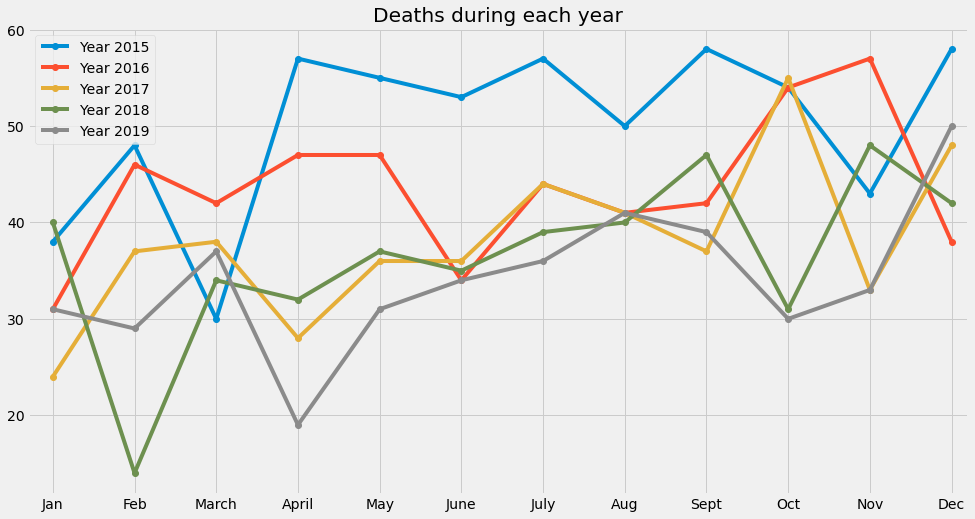

In [152]:
months = ['Jan', 'Feb', 'March', "April", 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(15, 8))
plt.plot(series.values[:12], marker='o', label='Year 2015')
plt.plot(series.values[12:24], marker='o', label='Year 2016')
plt.plot(series.values[24:36], marker='o', label='Year 2017')
plt.plot(series.values[36:48], marker='o', label='Year 2018')
plt.plot(series.values[48:60], marker='o', label='Year 2019')
plt.title('Deaths during each year')
plt.xticks(ticks=np.arange(12), labels=months)
plt.xlim(-0.3, 11.2)
plt.legend()
plt.show()

### Сравним несколько моделей между собой, будем использовать `AutoARIMA`, `TBATS`, `Prophet`

In [158]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as MAPE

1. ARIMA

In [160]:
forecaster = AutoARIMA(sp=12, 
                       start_p=0, d=None, start_q=1, 
                       max_p=3, max_d=2, max_q=3, 
                       suppress_warnings=True)
forecaster.fit(train)
pred = forecaster.predict(fh=np.arange(12))

2. TBATS

In [161]:
from sktime.forecasting.tbats import TBATS

tbats = TBATS(
     use_box_cox=True,
     use_trend=True,
     use_damped_trend=False,
     sp=12,
     use_arma_errors=True,
     n_jobs=1)
tbats.fit(train)
tbats_pred = tbats.predict(fh=np.arange(12))

3. Prophet

In [162]:
from sktime.forecasting.fbprophet import Prophet

train.index = train.index.to_timestamp(freq="M")
pph = Prophet(
    seasonality_mode='additive',
    growth = 'linear',
    n_changepoints=int(len(train) / 12),
    yearly_seasonality=True,
    mcmc_samples=1000)

pph.fit(train)
pph_pred = pph.predict(fh=np.arange(12))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Визуализируем графики предсказанных трайекторий и сравним модели по MAPE

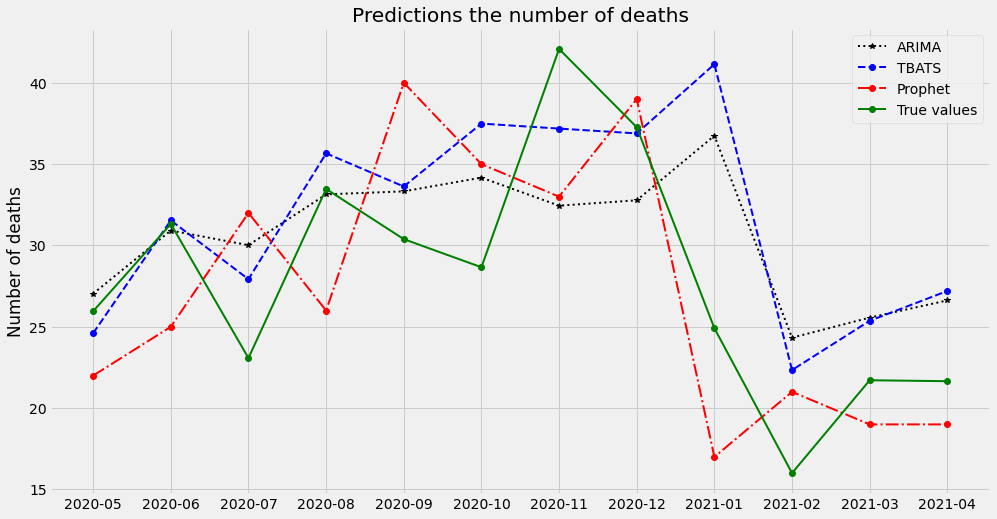

In [168]:
labels = ['2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04']

plt.figure(figsize=(15, 8))

plt.plot(pred.values, '*k:', lw = 2, label='ARIMA') 
plt.plot(tbats_pred.values, 'b--o', lw = 2, label='TBATS')
plt.plot(test.values, 'r-.o', lw = 2,  label='Prophet')

plt.plot(pph_pred.values, "g-o", lw = 2, label='True values')
plt.ylabel('Number of deaths')
plt.xticks(ticks=np.arange(12), labels=labels)
plt.title('Predictions the number of deaths')
plt.legend()
plt.show()

In [167]:
print(f"MAPE for ARIMA is {MAPE(test.values, pred.values)}")
print(f"MAPE for TBATS is {MAPE(test.values, tbats_pred.values)}")
print(f"MAPE for Prophet is {MAPE(test.values, pph_pred.values)}")

MAPE for ARIMA is 0.2696668592254119
MAPE for TBATS is 0.29511801188327763
MAPE for Prophet is 0.22715705974352987
